# Train GAN / Discriminator part

In [33]:
import logging
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn
from torch.nn import functional as F
import seaborn as sns
import random

import importlib
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)

sns.set()

DEVICE = 'cuda'

logging.basicConfig(
        format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
        level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)
logging.info('start')

2019-04-24 21:09:54,683 root         INFO     start


In [34]:
def train_gan(epoch, train_loader, modules, optimizers):
    for module in modules.values():
        module.train()
 
    total_loss_discriminator = 0
    total_loss_generator = 0
    total_loss = 0

    n_data = len(train_loader.dataset)
    n_batches = len(train_loader)

    for batch_idx, batch_data in enumerate(train_loader):
        if DEBUG and batch_idx > 3:
            continue

        batch_data = batch_data[0].to(DEVICE)
        n_batch_data = len(batch_data)

        for optimizer in optimizers.values():
                optimizer.zero_grad()

        decoder = modules['decoder']

        z_from_prior = toynn.sample_from_prior(
                    LATENT_DIM, n_samples=n_batch_data).to(DEVICE)
        batch_from_prior, batch_logvarx_from_prior = decoder(
                    z_from_prior)

        discriminator = modules['discriminator']

        real_labels = torch.full((n_batch_data, 1), 1, device=DEVICE)
        fake_labels = torch.full((n_batch_data, 1), 0, device=DEVICE)
        #noise_for_real_labels = np.random.normal(loc=0, scale=0.1, size=(n_batch_data, 1))
        #noise_for_fake_labels = np.random.normal(loc=0, scale=0.1, size=(n_batch_data, 1))
        #real_labels = real_labels - torch.Tensor(np.abs(noise_for_real_labels)).to(DEVICE)
        #fake_labels = fake_labels + torch.Tensor(np.abs(noise_for_fake_labels)).to(DEVICE)
        
        #noise_for_data = np.random.normal(loc=0, scale=2, size=(n_batch_data, 1))
        #noise_for_prior = np.random.normal(loc=0, scale=2, size=(n_batch_data, 1))
        noisy_batch_data = batch_data #+ torch.Tensor(noise_for_data).to(DEVICE)
        noisy_batch_from_prior = batch_from_prior #+ torch.Tensor(noise_for_prior).to(DEVICE)

        labels_data = discriminator(noisy_batch_data)
        labels_from_prior = discriminator(noisy_batch_from_prior)

        
        criterion = torch.nn.BCELoss()
        
        loss_dis_data = criterion(
                        labels_data,
                        real_labels)
        loss_dis_from_prior = criterion(
                        labels_from_prior,
                        fake_labels)

        loss_discriminator = (
                    loss_dis_data + loss_dis_from_prior)

        loss_discriminator.backward(retain_graph=True)
        #logging.info('Discriminator gradients')
        #for name, param in discriminator.named_parameters():
            #logging.info(name)
            #logging.info(param.grad)
        
        optimizers['discriminator'].step()

        loss_generator = criterion(
                    labels_from_prior,
                    real_labels)
        loss_generator.backward()
        
        #logging.info('Decoder gradients')
        #for name, param in decoder.named_parameters():
            #logging.info(name)
            #logging.info(param.grad)

        optimizers['decoder'].step()

        loss = loss_discriminator + loss_generator

        if batch_idx % PRINT_INTERVAL == 0:
            batch_loss = loss / n_batch_data
            batch_loss_discriminator = loss_discriminator / n_batch_data
            batch_loss_generator = loss_generator / n_batch_data

            dx = labels_data.mean()
            dgz = labels_from_prior.mean()

            string_base = (
                    'Train Epoch: {} [{}/{} ({:.0f}%)]\tTotal Loss: {:.6f}'
                    ', Discriminator: {:.6f}; Generator: {:.6f},'
                    '\nD(x): {:.3f}, D(G(z)): {:.3f}')
            logging.info(
                    string_base.format(
                        epoch, batch_idx * n_batch_data, n_data,
                        100. * batch_idx / n_batches,
                        batch_loss,
                        batch_loss_discriminator,
                        batch_loss_generator,
                        dx, dgz))

        total_loss_discriminator += loss_discriminator.item()
        total_loss_generator += loss_generator.item()

        total_loss += loss.item()

    average_loss = total_loss / n_data

    logging.info('====> Epoch: {} Average loss: {:.4f}'.format(
                epoch, average_loss))
    
    train_losses = {}
    train_losses['total'] = average_loss
    return train_losses

# Generate data

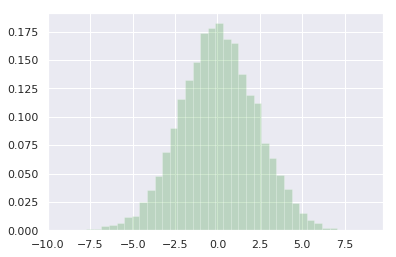

In [35]:
w_true = 2
color_true = 'green'

def generate_synthetic_1d(w=w_true, n=10):
    z = np.random.normal(loc=0, scale=1, size=(n, 1))
    eps = np.random.normal(loc=0, scale=1, size=(n, 1))

    x = w * z + eps
    return x

dataset = generate_synthetic_1d(w=w_true, n=10000)
fig, ax = plt.subplots()
ax = toyvis.plot_data(dataset, color=color_true, label='from decoder true', ax=ax)

# Initialize decoder

In [36]:
DEBUG = False

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")

# Seed
SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DATA_DIM = 1
LATENT_DIM = 1
N_DECODER_LAYERS = 1
NONLINEARITY = False
N_SAMPLES = 10000
WITH_BIASX = False
WITH_LOGVARX = False
WITH_BIASZ = False
WITH_LOGVARZ = False

FRAC_TEST = 0.2
BATCH_SIZE = 32
KWARGS = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

PRINT_INTERVAL = 16
torch.backends.cudnn.benchmark = True

N_EPOCHS = 50
LR = 1e-3

BETA1 = 0.5
BETA2 = 0.999

In [37]:
logging.info('--Dataset tensor: (%d, %d)' % dataset.shape)

n_train = int((1 - FRAC_TEST) * N_SAMPLES)
train = torch.Tensor(dataset[:n_train, :])

logging.info('-- Train tensor: (%d, %d)' % train.shape)
train_dataset = torch.utils.data.TensorDataset(train)
train_loader = torch.utils.data.DataLoader(
train_dataset, batch_size=BATCH_SIZE, shuffle=True, **KWARGS)

decoder = toynn.Decoder(
            latent_dim=LATENT_DIM,
            data_dim=DATA_DIM,
            n_layers=N_DECODER_LAYERS,
            nonlinearity=NONLINEARITY,
            with_biasx=WITH_BIASX,
            with_logvarx=WITH_LOGVARX).to(DEVICE)

# Set the value of the decoder to the biased value we know happens

decoder.layers[0].weight.data = torch.tensor([[1.10]]).to(DEVICE)

discriminator = toynn.Discriminator(data_dim=DATA_DIM).to(DEVICE)

modules = {}
modules['decoder'] = decoder
modules['discriminator'] = discriminator

logging.info('Values of VAE\'s decoder parameters before training:')
for name, param in decoder.named_parameters():
    logging.info(name)
    logging.info(param.data)

optimizers = {}
optimizers['decoder'] = torch.optim.Adam(
    modules['decoder'].parameters(), lr=LR, betas=(BETA1, BETA2))
optimizers['discriminator'] = torch.optim.SGD(
    modules['discriminator'].parameters(), lr=LR)


def init_xavier_normal(m):
    if type(m) == tnn.Linear:
        tnn.init.xavier_normal_(m.weight)

    for module in modules.values():
        module.apply(init_xavier_normal)

train_losses_all_epochs = []

for epoch in range(N_EPOCHS):
    if DEBUG:
        if epoch > 2:
            break

    train_losses = train_gan(
                epoch, train_loader, modules, optimizers)
    train_losses_all_epochs.append(train_losses)

2019-04-24 21:09:55,598 root         INFO     --Dataset tensor: (10000, 1)
2019-04-24 21:09:55,600 root         INFO     -- Train tensor: (8000, 1)
2019-04-24 21:09:55,609 root         INFO     Values of VAE's decoder parameters before training:
2019-04-24 21:09:55,610 root         INFO     layers.0.weight
2019-04-24 21:09:55,611 root         INFO     tensor([[1.1000]], device='cuda:0')
2019-04-24 21:09:55,670 root         INFO     Train Epoch: 0 [0/8000 (0%)]	Total Loss: 0.059782, Discriminator: 0.046017; Generator: 0.013765,
D(x): 0.644, D(G(z)): 0.644
2019-04-24 21:09:55,762 root         INFO     Train Epoch: 0 [512/8000 (6%)]	Total Loss: 0.059810, Discriminator: 0.045906; Generator: 0.013904,
D(x): 0.641, D(G(z)): 0.641
2019-04-24 21:09:55,854 root         INFO     Train Epoch: 0 [1024/8000 (13%)]	Total Loss: 0.059841, Discriminator: 0.045802; Generator: 0.014039,
D(x): 0.638, D(G(z)): 0.638
2019-04-24 21:09:55,946 root         INFO     Train Epoch: 0 [1536/8000 (19%)]	Total Loss: 

2019-04-24 21:09:59,817 root         INFO     Train Epoch: 2 [6144/8000 (77%)]	Total Loss: 0.061746, Discriminator: 0.043833; Generator: 0.017913,
D(x): 0.564, D(G(z)): 0.564
2019-04-24 21:09:59,908 root         INFO     Train Epoch: 2 [6656/8000 (83%)]	Total Loss: 0.061792, Discriminator: 0.043815; Generator: 0.017977,
D(x): 0.563, D(G(z)): 0.563
2019-04-24 21:09:59,998 root         INFO     Train Epoch: 2 [7168/8000 (90%)]	Total Loss: 0.061837, Discriminator: 0.043797; Generator: 0.018040,
D(x): 0.561, D(G(z)): 0.561
2019-04-24 21:10:00,088 root         INFO     Train Epoch: 2 [7680/8000 (96%)]	Total Loss: 0.061882, Discriminator: 0.043780; Generator: 0.018102,
D(x): 0.560, D(G(z)): 0.560
2019-04-24 21:10:00,173 root         INFO     ====> Epoch: 2 Average loss: 0.0615
2019-04-24 21:10:00,220 root         INFO     Train Epoch: 3 [0/8000 (0%)]	Total Loss: 0.061909, Discriminator: 0.043769; Generator: 0.018140,
D(x): 0.560, D(G(z)): 0.560
2019-04-24 21:10:00,313 root         INFO     T

2019-04-24 21:10:04,171 root         INFO     Train Epoch: 5 [5120/8000 (64%)]	Total Loss: 0.063375, Discriminator: 0.043420; Generator: 0.019955,
D(x): 0.528, D(G(z)): 0.528
2019-04-24 21:10:04,264 root         INFO     Train Epoch: 5 [5632/8000 (70%)]	Total Loss: 0.063402, Discriminator: 0.043417; Generator: 0.019985,
D(x): 0.528, D(G(z)): 0.528
2019-04-24 21:10:04,357 root         INFO     Train Epoch: 5 [6144/8000 (77%)]	Total Loss: 0.063428, Discriminator: 0.043413; Generator: 0.020015,
D(x): 0.527, D(G(z)): 0.527
2019-04-24 21:10:04,447 root         INFO     Train Epoch: 5 [6656/8000 (83%)]	Total Loss: 0.063454, Discriminator: 0.043410; Generator: 0.020044,
D(x): 0.527, D(G(z)): 0.527
2019-04-24 21:10:04,539 root         INFO     Train Epoch: 5 [7168/8000 (90%)]	Total Loss: 0.063480, Discriminator: 0.043407; Generator: 0.020073,
D(x): 0.526, D(G(z)): 0.526
2019-04-24 21:10:04,631 root         INFO     Train Epoch: 5 [7680/8000 (96%)]	Total Loss: 0.063505, Discriminator: 0.043404;

2019-04-24 21:10:08,606 root         INFO     Train Epoch: 8 [4096/8000 (51%)]	Total Loss: 0.064246, Discriminator: 0.043340; Generator: 0.020906,
D(x): 0.512, D(G(z)): 0.512
2019-04-24 21:10:08,696 root         INFO     Train Epoch: 8 [4608/8000 (58%)]	Total Loss: 0.064259, Discriminator: 0.043340; Generator: 0.020919,
D(x): 0.512, D(G(z)): 0.512
2019-04-24 21:10:08,788 root         INFO     Train Epoch: 8 [5120/8000 (64%)]	Total Loss: 0.064272, Discriminator: 0.043339; Generator: 0.020933,
D(x): 0.512, D(G(z)): 0.512
2019-04-24 21:10:08,880 root         INFO     Train Epoch: 8 [5632/8000 (70%)]	Total Loss: 0.064285, Discriminator: 0.043338; Generator: 0.020946,
D(x): 0.512, D(G(z)): 0.512
2019-04-24 21:10:08,972 root         INFO     Train Epoch: 8 [6144/8000 (77%)]	Total Loss: 0.064297, Discriminator: 0.043338; Generator: 0.020959,
D(x): 0.511, D(G(z)): 0.511
2019-04-24 21:10:09,063 root         INFO     Train Epoch: 8 [6656/8000 (83%)]	Total Loss: 0.064309, Discriminator: 0.043337;

2019-04-24 21:10:12,946 root         INFO     Train Epoch: 11 [3072/8000 (38%)]	Total Loss: 0.064657, Discriminator: 0.043325; Generator: 0.021332,
D(x): 0.505, D(G(z)): 0.505
2019-04-24 21:10:13,038 root         INFO     Train Epoch: 11 [3584/8000 (45%)]	Total Loss: 0.064663, Discriminator: 0.043325; Generator: 0.021338,
D(x): 0.505, D(G(z)): 0.505
2019-04-24 21:10:13,128 root         INFO     Train Epoch: 11 [4096/8000 (51%)]	Total Loss: 0.064669, Discriminator: 0.043325; Generator: 0.021344,
D(x): 0.505, D(G(z)): 0.505
2019-04-24 21:10:13,217 root         INFO     Train Epoch: 11 [4608/8000 (58%)]	Total Loss: 0.064675, Discriminator: 0.043325; Generator: 0.021350,
D(x): 0.505, D(G(z)): 0.505
2019-04-24 21:10:13,310 root         INFO     Train Epoch: 11 [5120/8000 (64%)]	Total Loss: 0.064680, Discriminator: 0.043325; Generator: 0.021356,
D(x): 0.505, D(G(z)): 0.505
2019-04-24 21:10:13,402 root         INFO     Train Epoch: 11 [5632/8000 (70%)]	Total Loss: 0.064686, Discriminator: 0.0

2019-04-24 21:10:17,293 root         INFO     Train Epoch: 14 [2048/8000 (26%)]	Total Loss: 0.064841, Discriminator: 0.043322; Generator: 0.021519,
D(x): 0.502, D(G(z)): 0.502
2019-04-24 21:10:17,385 root         INFO     Train Epoch: 14 [2560/8000 (32%)]	Total Loss: 0.064844, Discriminator: 0.043322; Generator: 0.021521,
D(x): 0.502, D(G(z)): 0.502
2019-04-24 21:10:17,477 root         INFO     Train Epoch: 14 [3072/8000 (38%)]	Total Loss: 0.064846, Discriminator: 0.043322; Generator: 0.021524,
D(x): 0.502, D(G(z)): 0.502
2019-04-24 21:10:17,569 root         INFO     Train Epoch: 14 [3584/8000 (45%)]	Total Loss: 0.064849, Discriminator: 0.043322; Generator: 0.021527,
D(x): 0.502, D(G(z)): 0.502
2019-04-24 21:10:17,661 root         INFO     Train Epoch: 14 [4096/8000 (51%)]	Total Loss: 0.064851, Discriminator: 0.043322; Generator: 0.021529,
D(x): 0.502, D(G(z)): 0.502
2019-04-24 21:10:17,753 root         INFO     Train Epoch: 14 [4608/8000 (58%)]	Total Loss: 0.064854, Discriminator: 0.0

2019-04-24 21:10:21,672 root         INFO     Train Epoch: 17 [1024/8000 (13%)]	Total Loss: 0.064922, Discriminator: 0.043322; Generator: 0.021600,
D(x): 0.501, D(G(z)): 0.501
2019-04-24 21:10:21,766 root         INFO     Train Epoch: 17 [1536/8000 (19%)]	Total Loss: 0.064923, Discriminator: 0.043322; Generator: 0.021601,
D(x): 0.501, D(G(z)): 0.501
2019-04-24 21:10:21,858 root         INFO     Train Epoch: 17 [2048/8000 (26%)]	Total Loss: 0.064924, Discriminator: 0.043322; Generator: 0.021602,
D(x): 0.501, D(G(z)): 0.501
2019-04-24 21:10:21,951 root         INFO     Train Epoch: 17 [2560/8000 (32%)]	Total Loss: 0.064925, Discriminator: 0.043322; Generator: 0.021603,
D(x): 0.501, D(G(z)): 0.501
2019-04-24 21:10:22,042 root         INFO     Train Epoch: 17 [3072/8000 (38%)]	Total Loss: 0.064926, Discriminator: 0.043322; Generator: 0.021604,
D(x): 0.501, D(G(z)): 0.501
2019-04-24 21:10:22,134 root         INFO     Train Epoch: 17 [3584/8000 (45%)]	Total Loss: 0.064927, Discriminator: 0.0

2019-04-24 21:10:25,911 root         INFO     ====> Epoch: 19 Average loss: 0.0650
2019-04-24 21:10:25,959 root         INFO     Train Epoch: 20 [0/8000 (0%)]	Total Loss: 0.064956, Discriminator: 0.043322; Generator: 0.021635,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:26,049 root         INFO     Train Epoch: 20 [512/8000 (6%)]	Total Loss: 0.064957, Discriminator: 0.043322; Generator: 0.021635,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:26,138 root         INFO     Train Epoch: 20 [1024/8000 (13%)]	Total Loss: 0.064957, Discriminator: 0.043322; Generator: 0.021636,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:26,227 root         INFO     Train Epoch: 20 [1536/8000 (19%)]	Total Loss: 0.064958, Discriminator: 0.043322; Generator: 0.021636,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:26,316 root         INFO     Train Epoch: 20 [2048/8000 (26%)]	Total Loss: 0.064958, Discriminator: 0.043322; Generator: 0.021637,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:26,404 root         INFO  

2019-04-24 21:10:30,197 root         INFO     Train Epoch: 22 [7168/8000 (90%)]	Total Loss: 0.064971, Discriminator: 0.043322; Generator: 0.021650,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:30,288 root         INFO     Train Epoch: 22 [7680/8000 (96%)]	Total Loss: 0.064972, Discriminator: 0.043322; Generator: 0.021650,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:30,371 root         INFO     ====> Epoch: 22 Average loss: 0.0650
2019-04-24 21:10:30,419 root         INFO     Train Epoch: 23 [0/8000 (0%)]	Total Loss: 0.064972, Discriminator: 0.043322; Generator: 0.021650,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:30,510 root         INFO     Train Epoch: 23 [512/8000 (6%)]	Total Loss: 0.064972, Discriminator: 0.043322; Generator: 0.021650,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:30,601 root         INFO     Train Epoch: 23 [1024/8000 (13%)]	Total Loss: 0.064972, Discriminator: 0.043322; Generator: 0.021650,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:30,693 root         INFO  

2019-04-24 21:10:34,488 root         INFO     Train Epoch: 25 [6144/8000 (77%)]	Total Loss: 0.064978, Discriminator: 0.043322; Generator: 0.021656,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:34,580 root         INFO     Train Epoch: 25 [6656/8000 (83%)]	Total Loss: 0.064978, Discriminator: 0.043322; Generator: 0.021656,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:34,672 root         INFO     Train Epoch: 25 [7168/8000 (90%)]	Total Loss: 0.064978, Discriminator: 0.043322; Generator: 0.021656,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:34,764 root         INFO     Train Epoch: 25 [7680/8000 (96%)]	Total Loss: 0.064978, Discriminator: 0.043322; Generator: 0.021656,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:34,850 root         INFO     ====> Epoch: 25 Average loss: 0.0650
2019-04-24 21:10:34,897 root         INFO     Train Epoch: 26 [0/8000 (0%)]	Total Loss: 0.064978, Discriminator: 0.043322; Generator: 0.021656,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:34,991 root         INFO

2019-04-24 21:10:38,813 root         INFO     Train Epoch: 28 [5120/8000 (64%)]	Total Loss: 0.064980, Discriminator: 0.043322; Generator: 0.021659,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:38,905 root         INFO     Train Epoch: 28 [5632/8000 (70%)]	Total Loss: 0.064980, Discriminator: 0.043322; Generator: 0.021659,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:38,996 root         INFO     Train Epoch: 28 [6144/8000 (77%)]	Total Loss: 0.064981, Discriminator: 0.043322; Generator: 0.021659,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:39,087 root         INFO     Train Epoch: 28 [6656/8000 (83%)]	Total Loss: 0.064981, Discriminator: 0.043322; Generator: 0.021659,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:39,178 root         INFO     Train Epoch: 28 [7168/8000 (90%)]	Total Loss: 0.064981, Discriminator: 0.043322; Generator: 0.021659,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:39,268 root         INFO     Train Epoch: 28 [7680/8000 (96%)]	Total Loss: 0.064981, Discriminator: 0.0

2019-04-24 21:10:43,133 root         INFO     Train Epoch: 31 [4096/8000 (51%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021660,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:43,224 root         INFO     Train Epoch: 31 [4608/8000 (58%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021660,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:43,314 root         INFO     Train Epoch: 31 [5120/8000 (64%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021660,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:43,405 root         INFO     Train Epoch: 31 [5632/8000 (70%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021660,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:43,496 root         INFO     Train Epoch: 31 [6144/8000 (77%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021660,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:43,587 root         INFO     Train Epoch: 31 [6656/8000 (83%)]	Total Loss: 0.064982, Discriminator: 0.0

2019-04-24 21:10:47,411 root         INFO     Train Epoch: 34 [3072/8000 (38%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021660,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:47,500 root         INFO     Train Epoch: 34 [3584/8000 (45%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021660,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:47,588 root         INFO     Train Epoch: 34 [4096/8000 (51%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021660,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:47,676 root         INFO     Train Epoch: 34 [4608/8000 (58%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021660,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:47,765 root         INFO     Train Epoch: 34 [5120/8000 (64%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021660,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:47,856 root         INFO     Train Epoch: 34 [5632/8000 (70%)]	Total Loss: 0.064982, Discriminator: 0.0

2019-04-24 21:10:51,738 root         INFO     Train Epoch: 37 [2048/8000 (26%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:51,830 root         INFO     Train Epoch: 37 [2560/8000 (32%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:51,923 root         INFO     Train Epoch: 37 [3072/8000 (38%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:52,013 root         INFO     Train Epoch: 37 [3584/8000 (45%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:52,105 root         INFO     Train Epoch: 37 [4096/8000 (51%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:52,197 root         INFO     Train Epoch: 37 [4608/8000 (58%)]	Total Loss: 0.064982, Discriminator: 0.0

2019-04-24 21:10:56,107 root         INFO     Train Epoch: 40 [1024/8000 (13%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:56,200 root         INFO     Train Epoch: 40 [1536/8000 (19%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:56,292 root         INFO     Train Epoch: 40 [2048/8000 (26%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:56,384 root         INFO     Train Epoch: 40 [2560/8000 (32%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:56,478 root         INFO     Train Epoch: 40 [3072/8000 (38%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:10:56,572 root         INFO     Train Epoch: 40 [3584/8000 (45%)]	Total Loss: 0.064982, Discriminator: 0.0

2019-04-24 21:11:00,416 root         INFO     ====> Epoch: 42 Average loss: 0.0650
2019-04-24 21:11:00,463 root         INFO     Train Epoch: 43 [0/8000 (0%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:00,555 root         INFO     Train Epoch: 43 [512/8000 (6%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:00,645 root         INFO     Train Epoch: 43 [1024/8000 (13%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:00,737 root         INFO     Train Epoch: 43 [1536/8000 (19%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:00,828 root         INFO     Train Epoch: 43 [2048/8000 (26%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:00,919 root         INFO  

2019-04-24 21:11:04,717 root         INFO     Train Epoch: 45 [7168/8000 (90%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:04,806 root         INFO     Train Epoch: 45 [7680/8000 (96%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:04,889 root         INFO     ====> Epoch: 45 Average loss: 0.0650
2019-04-24 21:11:04,937 root         INFO     Train Epoch: 46 [0/8000 (0%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:05,030 root         INFO     Train Epoch: 46 [512/8000 (6%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:05,121 root         INFO     Train Epoch: 46 [1024/8000 (13%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:05,212 root         INFO  

2019-04-24 21:11:09,042 root         INFO     Train Epoch: 48 [6144/8000 (77%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:09,133 root         INFO     Train Epoch: 48 [6656/8000 (83%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:09,223 root         INFO     Train Epoch: 48 [7168/8000 (90%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:09,314 root         INFO     Train Epoch: 48 [7680/8000 (96%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:09,397 root         INFO     ====> Epoch: 48 Average loss: 0.0650
2019-04-24 21:11:09,444 root         INFO     Train Epoch: 49 [0/8000 (0%)]	Total Loss: 0.064982, Discriminator: 0.043322; Generator: 0.021661,
D(x): 0.500, D(G(z)): 0.500
2019-04-24 21:11:09,536 root         INFO

2019-04-24 21:11:10,910 root         INFO     Values of VAE's decoder parameters after training:
2019-04-24 21:11:10,910 root         INFO     layers.0.weight
2019-04-24 21:11:10,910 root         INFO     tensor([[1.1000]], device='cuda:0')


Last losses:
[0.06498245894908905, 0.06498245894908905, 0.06498245894908905, 0.06498245894908905, 0.06498245894908905]
1.1


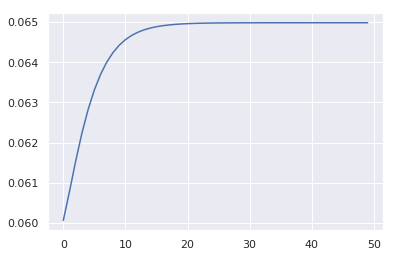

In [38]:
plt.figure()
train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
n_epochs = len(train_losses_total)
plt.plot(range(n_epochs), train_losses_total)
print('Last losses:')
print(train_losses_total[-5:])

logging.info('Values of VAE\'s decoder parameters after training:')
for name, param in decoder.named_parameters():
    logging.info(name)
    logging.info(param.data)
    w_learnt = param.data[0,0].cpu().numpy()
print(w_learnt)

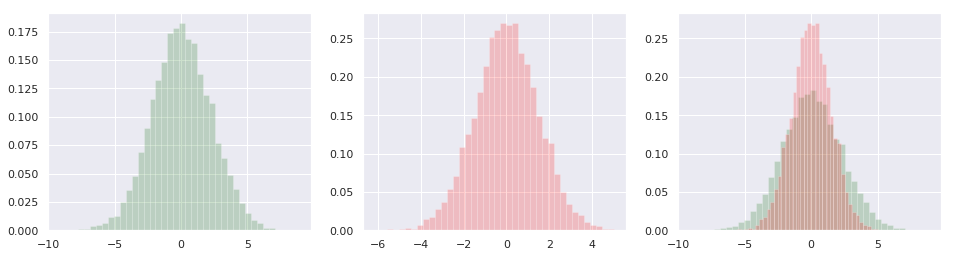

In [39]:
n_samples = 10000
#generated_x = toynn.generate_from_decoder(decoder, n_samples)
generated_x = generate_synthetic_1d(w=w_learnt, n=n_samples)
                                    
# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(dataset, color='darkgreen', ax=ax)

ax = axes[1]
toyvis.plot_data(generated_x, color='red', ax=ax)

ax = axes[2]
toyvis.plot_data(dataset, color='darkgreen', ax=ax, label='true')
toyvis.plot_data(generated_x, color='red', ax=ax, label='vae estimate')